<a href="https://colab.research.google.com/github/shashwat2820/deep-learning/blob/main/complete_mnist_mlp_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch 
import numpy as np 


In [ ]:
# The MNIST datasets are hosted on yann.lecun.com that has moved under CloudFlare protection
# Run this script to enable the datasets download
# Reference: https://github.com/pytorch/vision/issues/1938

from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)


In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocess used for data loading 
num_workers = 0 

# number of images per batch to load
batch_size = 20 

# percentage of training set to be used for validation 

valid_size = 0.2

# convert data to torch.FloatTensor()
transform  = transforms.ToTensor()

# choosing the training and testing dataset

train_data = datasets.MNIST(root = 'data' , train = True , download = True , transform  = transform)
test_data = datasets.MNIST(root = 'data' , train = False , download = True , transform  = transform)

# obtaining training indices that will be used for validation 
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx , valid_idx = indices[split:] , indices[:split]


# define samplers for obtaining the training and validation batches 

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# preparing data loaders 
train_loader = torch.utils.data.DataLoader(train_data , batch_size = batch_size , sampler = train_sampler , num_workers = num_workers )

valid_loader = torch.utils.data.DataLoader(train_data  , batch_size = batch_size , sampler = valid_sampler , num_workers = num_workers)

test_loader = torch.utils.data.DataLoader(test_data , batch_size = batch_size , num_workers = num_workers)



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


visualising the batch of training data 

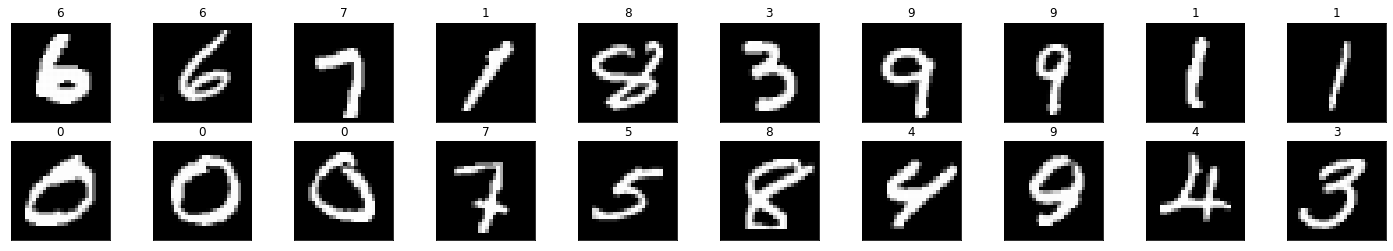

In [ ]:
import matplotlib.pyplot as plt 
%matplotlib inline

# obtaining one batch of the training images 

dataiter = iter(train_loader)
images , labels  = dataiter.next()
images = images.numpy()

# visualizing the enttre batch of training data 

fig = plt.figure(figsize = (25,4))
for idx in np.arange(20):
    ax = fig.add_subplot( 2 , 20/2 , idx+1 , xticks=[] , yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
  # print out the correct label for each image
  # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

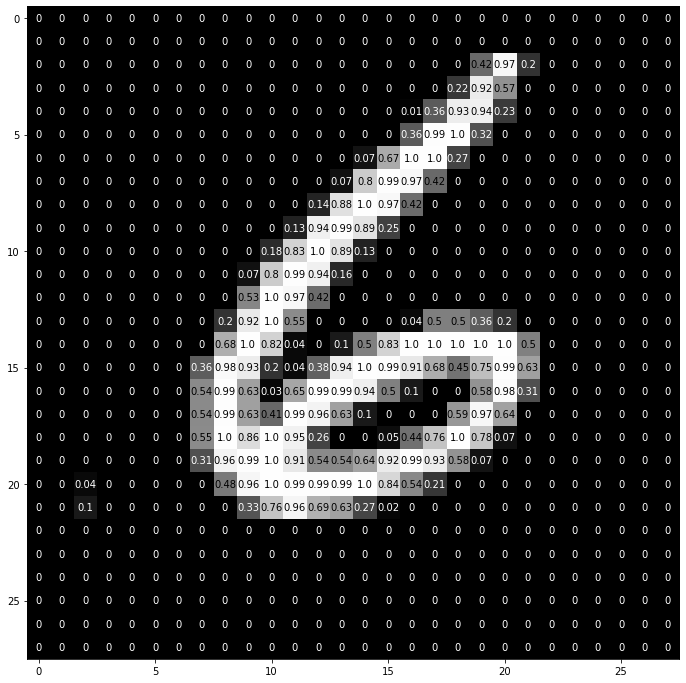

In [ ]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

**Defining the architecture of the model**



In [ ]:
import torch.nn as nn 
import torch.nn.functional as F 

class NET(nn.Module):
  def __init__(self):
    super(NET , self).__init__()

    hidden_1 = 512 
    hidden_2 = 512 

    #defining the input layer (784 -> hidden_1)
    self.fc1 = nn.Linear(28*28 , hidden_1)
    # definig the first fully connected hidden layer (hidden_1 -> hidden_2)
    self.fc2 = nn.Linear(hidden_1 , hidden_2)
    # defining the output layer (hidden_2 -> output_layer)
    self.fc3 = nn.Linear(hidden_2 , 10)

    #defining the dropout layer
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):

   # flatten the image input
    x = x.view(-1 , 28*28)

    # add the the hidden layer with relu activation function and dropout layer
    x = self.dropout(F.relu(self.fc1(x)))
    # add the the hidden layer with relu activation function and dropout layer
    x = self.dropout(F.relu(self.fc2(x)))
    #add the output layer with log_softmax activation 
    x = self.fc3(x) 

    return x


model = NET()
print(model)






NET(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


specifying the loss function and the optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters() , lr = 0.01)

**Training the model** 

In [ ]:
#number of epochsa to train the model
epochs = 50

# initialize the tracker for minimum validation loss 

valid_loss_min = np.Inf

# determining the training and validation epoch count 
for epoch in range(epochs):
  train_loss = 0.0
  valid_loss = 0.0
  
  # preparing the model for training  
  model.train()

  #loading the images and lables from the train loader
  #batch loop
  for data , target in train_loader:

    #setting the optimizer to zero grad inorder to in order to remove the gradient of the optimized variables  
    optimizer.zero_grad()
    #forward pass : compute predicted outputs by passing inputs into the model
    output = model(data)
    #calculating the loss
    loss = criterion(output , target )
    #backward propagation : compute the gradient of the loss with respect to the model parameters 
    loss.backward()
    #perform a single optimization step(parameter update)
    optimizer.step()
    #update running training loss
    train_loss += loss.item()*data.size(0) 


# model validation

  model.eval()#preparing the model for evaluation 
  #batch loop
  for data , target in valid_loader:
   #forward pass : compute predicted outputs by passing inputs into the model 
   ouput = model(data)
   #calculating the loss
   loss = criterion(output , target)
   #update the running valiadtion loss
   valid_loss += loss.item()*data.size(0) # we multiply the loss averaged over a batch to the batch size in order to get an aggregrate loss 

#calculating the training and valiadtion stattistics 
#calculate the average loss over an epoch by dividing the accumulated loss by total number of images in the training set
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss/len(valid_loader.dataset)

  print('Epoch:{} \t Train_loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1 , train_loss , valid_loss))

# if the validation loss is less than the valid_min loss , update it and save the model
  if valid_loss <= valid_loss_min:
     print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
     torch.save(model.state_dict(), 'model.pt')
     valid_loss_min = valid_loss




Epoch:1 	 Train_loss: 0.755478 	Validation Loss: 1.331045
Validation loss decreased (inf --> 1.331045).  Saving model ...
Epoch:2 	 Train_loss: 0.287606 	Validation Loss: 1.605244
Epoch:3 	 Train_loss: 0.228277 	Validation Loss: 1.581708
Epoch:4 	 Train_loss: 0.189255 	Validation Loss: 1.521915
Epoch:5 	 Train_loss: 0.162904 	Validation Loss: 1.744466
Epoch:6 	 Train_loss: 0.140044 	Validation Loss: 1.745193
Epoch:7 	 Train_loss: 0.123649 	Validation Loss: 1.688372
Epoch:8 	 Train_loss: 0.110854 	Validation Loss: 1.810328
Epoch:9 	 Train_loss: 0.100044 	Validation Loss: 1.968874
Epoch:10 	 Train_loss: 0.090695 	Validation Loss: 2.006301
Epoch:11 	 Train_loss: 0.083290 	Validation Loss: 2.030730
Epoch:12 	 Train_loss: 0.077299 	Validation Loss: 2.212762
Epoch:13 	 Train_loss: 0.070999 	Validation Loss: 2.162267
Epoch:14 	 Train_loss: 0.065515 	Validation Loss: 2.118368
Epoch:15 	 Train_loss: 0.061187 	Validation Loss: 2.290879
Epoch:16 	 Train_loss: 0.057991 	Validation Loss: 2.141874
E

load the model with the lowest valiadtion loss 

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

**Test the Trained Network**

Finally, we test our best model on previously unseen test data and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [ ]:
# initialise lists to monitor test loss and accuarcy 
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() #prep model for evaluation 

for data , target in test_loader:
  #forward pass: compute predicted outputs by passing inputs into the model
  output = model(data)
  #calculate the loss 
  loss = criterion(output , target)
  #update test loss 
  test_loss += loss.item()*data.size(0)
  # convert output probabilties to predict class 
  _,pred = torch.max(output , 1)

  #compare predictions to true labels 
  correct = np.squeeze(pred.eq(target.data.view_as(pred)))

  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] +=1


#calculate and print average test loss for an entire epoch

test_loss  = test_loss/len(test_loader.dataset)
print('test loss {:.6f} \n'.format(test_loss))

#printing the calss wise accuracy
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))
    


test loss 0.359794 

Test Accuracy of     0: 97% (957/980)
Test Accuracy of     1: 97% (1102/1135)
Test Accuracy of     2: 85% (880/1032)
Test Accuracy of     3: 86% (872/1010)
Test Accuracy of     4: 90% (885/982)
Test Accuracy of     5: 84% (756/892)
Test Accuracy of     6: 93% (892/958)
Test Accuracy of     7: 89% (924/1028)
Test Accuracy of     8: 83% (811/974)
Test Accuracy of     9: 88% (896/1009)

Test Accuracy (Overall): 89% (8975/10000)


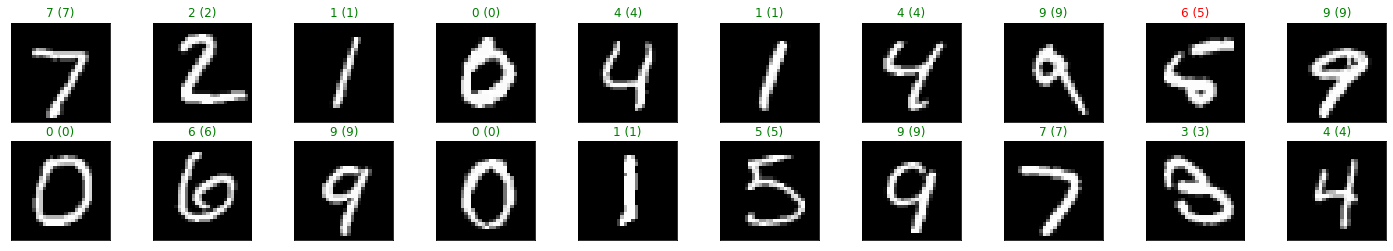

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))